# Tonnetz Diffusion

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import numpy as np
import statsmodels.api as sm

In [2]:
intervals = ['+P5', '-P5', '+m3', '-m3', '+M3', '-M3']

In [23]:
def plot_parameters(df, c_range, labels=None):
    
    fig, axes = plt.subplots(3,2,figsize=(16,10))
    axes = axes.flatten()

    for i, l, ax in zip(range(c_range[0], c_range[1]+1), labels, axes):
        sc = sns.regplot(
            x='year', 
            y=str(i), 
            data=df[df[str(i)]>0], 
            scatter_kws={'alpha':.3}, 
            line_kws={'color':'k'},
            marker='+',
            lowess=True,
            ax=ax
        )
        ax.set_ylabel(l)
        ax.set_xlabel('')
    plt.tight_layout()
    return fig

In [21]:
def bootstrap_lowess(df, c_range, labels=None, B=100, scatter=True):
    fig, axes = plt.subplots(3,2,figsize=(16,10))
    axes = axes.flatten()

    for i, l, ax in zip(range(c_range[0], c_range[1]+1), labels, axes):
        if scatter:
            sns.regplot(
            x='year', 
            y=str(i), 
            data=df[df[str(i)]>0], 
            scatter_kws={'alpha':.2}, 
            marker='+',
            fit_reg=False,
            ax=ax
        )
        
        for b in range(B):
            b_sample = df[[str(i), 'year']].sample(df.shape[0], replace=True)

            x = b_sample.year.values
            y = b_sample[str(i)].values
            lowess = sm.nonparametric.lowess(y, x, frac=0.3)

            ax.plot(lowess[:, 0], lowess[:, 1], alpha=.05, c='k')
        ax.set_ylabel(l)

    plt.tight_layout()
    return fig

In [15]:
cols = ['JSDs'] + [str(i) for i in range(12)] + ['file'] + ['composer'] + ['year']
df = pd.read_csv('results.tsv', sep='\t', names=cols, header=0).sort_values(by='year')
df.head()

,JSDs,0,1,2,3,4,5,6,7,8,9,10,11,file,composer,year
1442,0.082131,0.340914,0.632240,7.403419e-19,3.151637e-03,2.369442e-02,8.765961e-17,0.733203,0.893502,6.852771e-01,0.129920,0.067856,6.137037e-01,..\ExtendedTonality\data\DataFrames\Virtutibus...,Vitry,1361.0
1443,0.062455,0.669057,0.241962,3.861786e-02,9.336871e-13,1.611529e-13,5.036231e-02,0.981455,0.423207,5.527872e-13,0.666220,0.619354,7.413898e-13,..\ExtendedTonality\data\DataFrames\Gratissima...,Vitry,1361.0
1444,0.084306,0.546899,0.453101,1.145053e-16,0.000000e+00,3.797418e-17,0.000000e+00,0.825137,0.881071,4.187719e-01,0.559761,0.378611,1.122226e-01,..\ExtendedTonality\data\DataFrames\Lugentium-...,Vitry,1361.0
1445,0.042667,0.561634,0.438366,4.000629e-17,8.746670e-17,1.521919e-16,7.014793e-17,0.893876,0.771316,3.005533e-01,0.617021,0.441614,8.065462e-02,..\ExtendedTonality\data\DataFrames\Rex-quem-m...,Vitry,1361.0
1400,0.045719,0.526563,0.473437,1.429368e-16,1.485737e-16,9.523765e-18,1.660025e-17,0.886907,0.791428,4.347314e-01,0.485341,0.239210,1.251366e-01,..\ExtendedTonality\data\DataFrames\Messe-de-N...,Machaut,1370.0


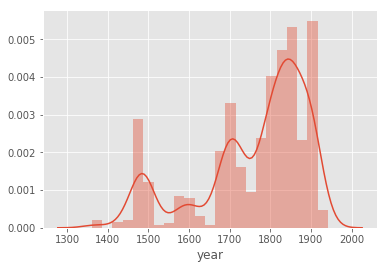

In [16]:
sns.distplot(df.year.dropna());

## Interval weights

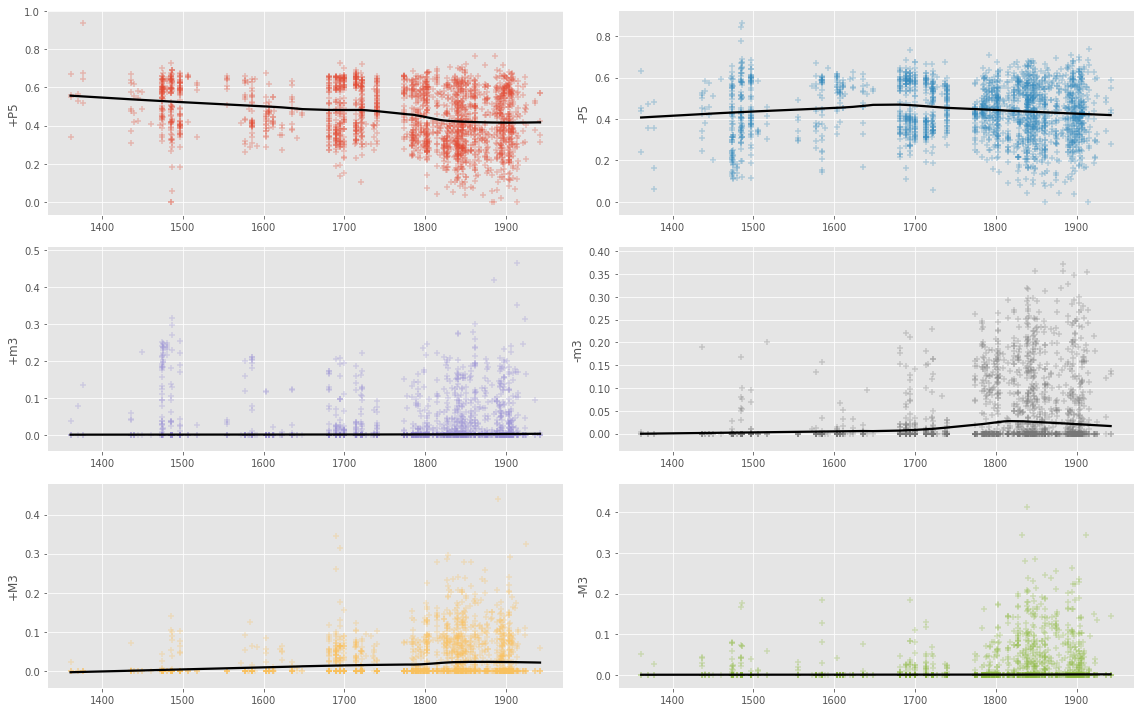

In [24]:
fig = plot_parameters(df, [0,5], labels=intervals)
plt.savefig('img/interval_weights.png', dpi=300)

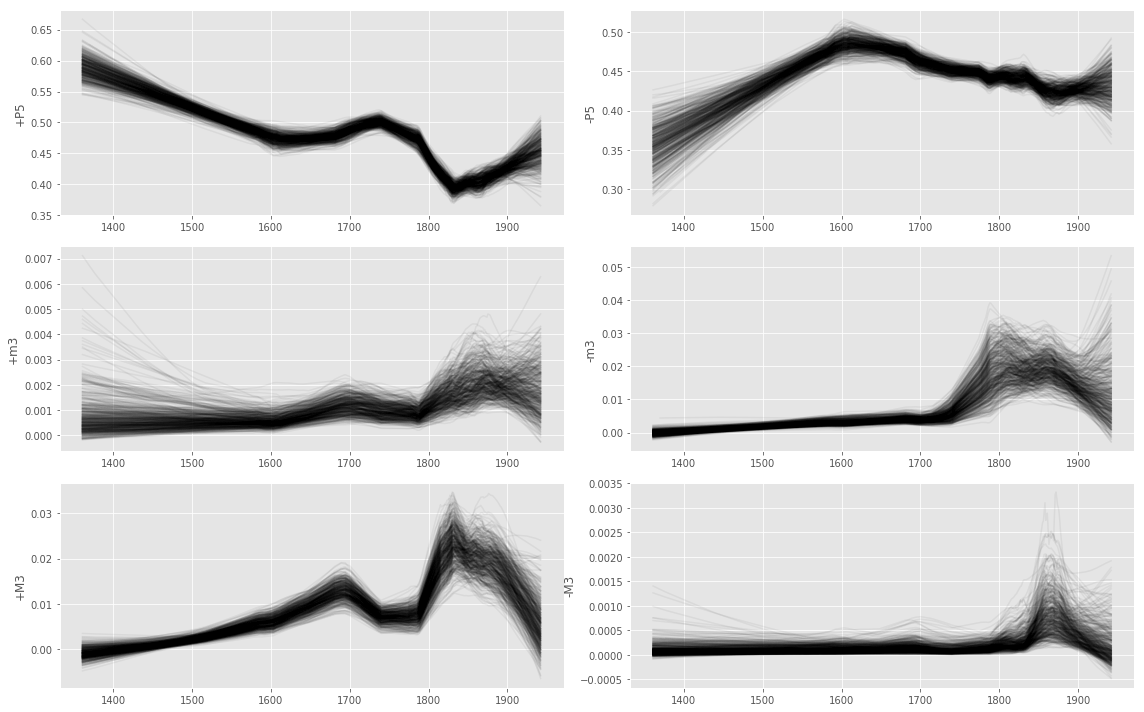

In [25]:
fig = bootstrap_lowess(df, [0,5], scatter=False, B=500, labels=intervals)
plt.savefig('img/bootstrapped_weights.png', dpi=300)

## Interval decays

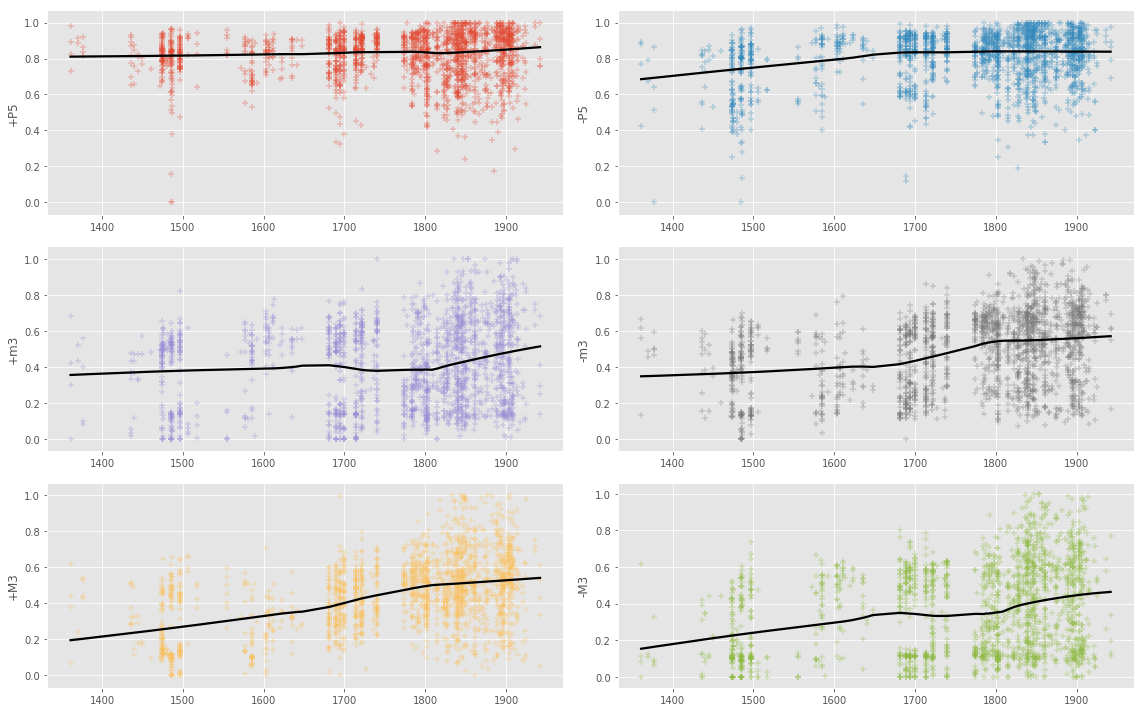

In [26]:
fig = plot_parameters(df, [6,12], labels=intervals)
plt.savefig('img/interval_params.png', dpi=300)

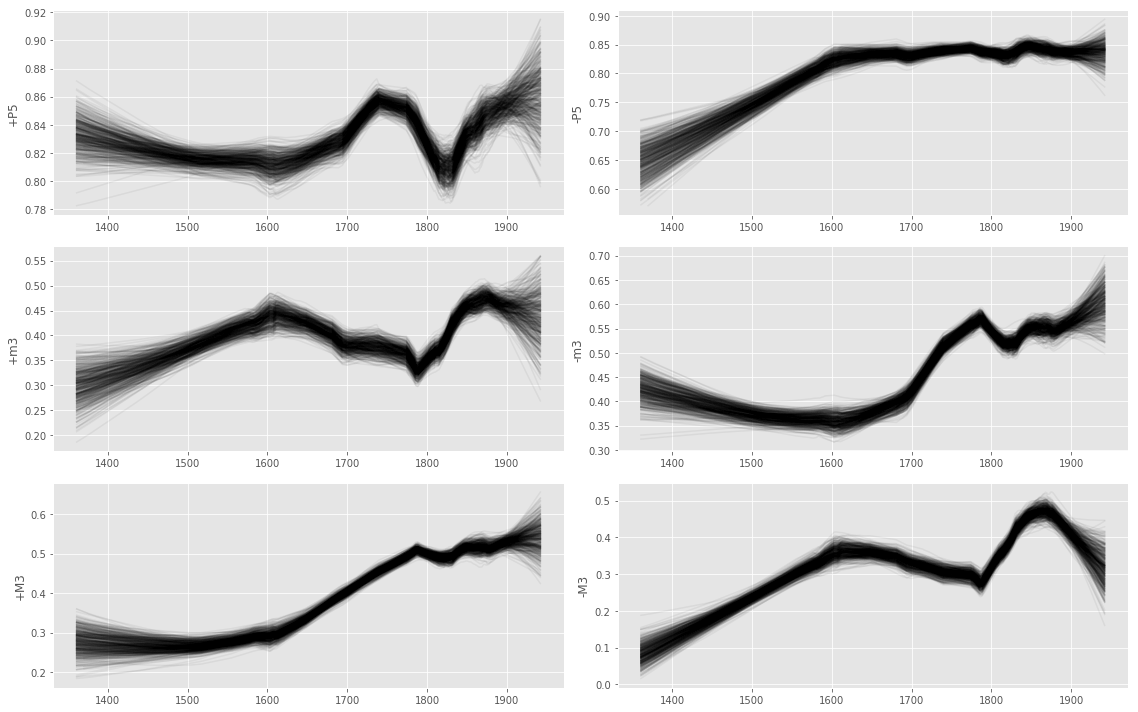

In [27]:
fig = bootstrap_lowess(df, [6,12], scatter=False, B=500, labels=intervals)
plt.savefig('img/bootstrapped_params.png', dpi=300)

## Divergences from true distributions per composer

In [84]:
df['sqrtJSDs'] = df['JSDs'].apply(np.sqrt)

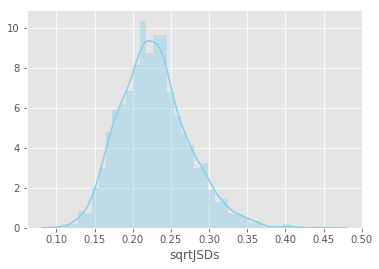

In [85]:
sns.distplot(df.sqrtJSDs, color='skyblue');

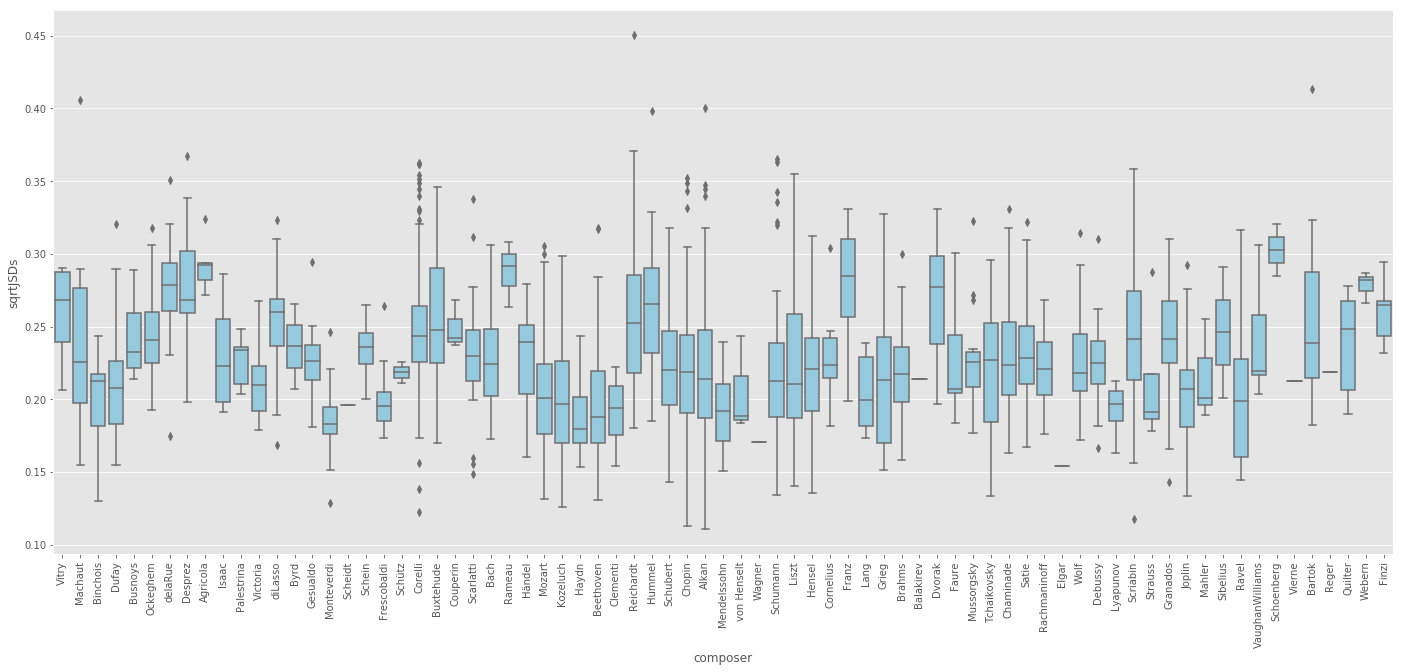

In [94]:
fig, ax = plt.subplots(figsize=(24,10))

sns.boxplot(
    x="composer", 
    y="sqrtJSDs",
    color='skyblue',
    data=df, ax=ax)

ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
# plt.ylim(0,1)
plt.show()

In [87]:
best = df.loc[df.sqrtJSDs.idxmin()]
best

JSDs                                                0.0122572
0                                                    0.291518
1                                                    0.450456
2                                                   0.0838312
3                                                    0.126512
4                                                   0.0274615
5                                                   0.0202213
6                                                     0.80718
7                                                    0.937718
8                                                    0.655795
9                                                    0.649903
10                                                    0.52406
11                                                   0.599993
file        ..\ExtendedTonality\data\DataFrames\Scherzo_Fo...
composer                                                Alkan
year                                                     1847
sqrtJSD 

In [90]:
worst = df.loc[df.sqrtJSDs.idxmax()]
worst

JSDs                                                 0.202936
0                                                    0.264343
1                                                    0.319134
2                                                    0.245465
3                                                 3.69264e-18
4                                                 8.71958e-18
5                                                    0.171058
6                                                    0.604325
7                                                    0.561993
8                                                    0.715919
9                                                   0.0933083
10                                                  0.0949692
11                                                   0.704033
file        ..\ExtendedTonality\data\DataFrames\Reichardt_...
composer                                            Reichardt
year                                                   1802.5
sqrtJSD 